In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('')

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


In [3]:
train_X = mnist.train._images.reshape((-1,28,28,1))
train_Y =mnist.train._labels
train_X.shape

(55000, 28, 28, 1)

In [4]:
test_X = mnist.test._images.reshape((-1,28,28,1))
test_Y =mnist.test._labels
test_X.shape

(10000, 28, 28, 1)

In [5]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

In [6]:
def convolutionize(x, conv_w, h = 1):
    return tf.nn.conv2d(input = x, filter = conv_w, strides = [1, h, h, 1], padding = 'SAME')

def pooling(wx):
    return tf.nn.max_pool(wx, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def create_network(X, scope='conv',reuse=False):
    with tf.variable_scope(scope,reuse=reuse):
        w1 = tf.Variable(tf.random_normal([3, 3, 1, 2], stddev = 0.5))
        b1 = tf.Variable(tf.zeros(shape = [2]))
        w2 = tf.Variable(tf.random_normal([3, 3, 2, 4], stddev = 0.5))
        b2 = tf.Variable(tf.zeros(shape = [4]))
        w3 = tf.Variable(tf.random_normal([3, 3, 4, 8], stddev = 0.5))
        b3 = tf.Variable(tf.zeros(shape = [8]))
        w4 = tf.Variable(tf.random_normal([128, 2], stddev = 0.5))
        b4 = tf.Variable(tf.zeros(shape = [2]))

        conv1 = pooling(tf.nn.relu(convolutionize(X, w1) + b1))
        conv2 = pooling(tf.nn.relu(convolutionize(conv1, w2) + b2))
        conv3 = pooling(tf.nn.relu(convolutionize(conv2, w3) + b3))
        conv3 = tf.reshape(conv3, [-1, 128])
        return tf.matmul(conv3, w4) + b4
    
class Siamese:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.Y = tf.placeholder(tf.int64,[None])
        
        self.embedded = create_network(self.X)
        
        self.cost, fraction = batch_all_triplet_loss(self.Y, self.embedded, margin=0.5, squared=False)
        self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cost)

In [7]:
sess = tf.InteractiveSession()
model = Siamese()
sess.run(tf.global_variables_initializer())

In [8]:
BATCH_SIZE = 128
EPOCH = 10

for i in range(EPOCH):
    total_loss = 0
    for k in range(0, (len(train_X)//BATCH_SIZE)*BATCH_SIZE, BATCH_SIZE):
        loss, _ = sess.run([model.cost,model.optimizer],feed_dict={model.X:train_X[k:k+BATCH_SIZE],
                                                                  model.Y:train_Y[k:k+BATCH_SIZE]})
        total_loss += loss
    total_loss /= (len(train_X)//BATCH_SIZE)
    print('epoch: %d, avg loss: %f'%(i+1,total_loss))

epoch: 1, avg loss: 0.720848
epoch: 2, avg loss: 0.534376
epoch: 3, avg loss: 0.538604
epoch: 4, avg loss: 0.539883
epoch: 5, avg loss: 0.538228
epoch: 6, avg loss: 0.538495
epoch: 7, avg loss: 0.537216
epoch: 8, avg loss: 0.539004
epoch: 9, avg loss: 0.537756
epoch: 10, avg loss: 0.539224


In [9]:
embed = model.embedded.eval({model.X: test_X})

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

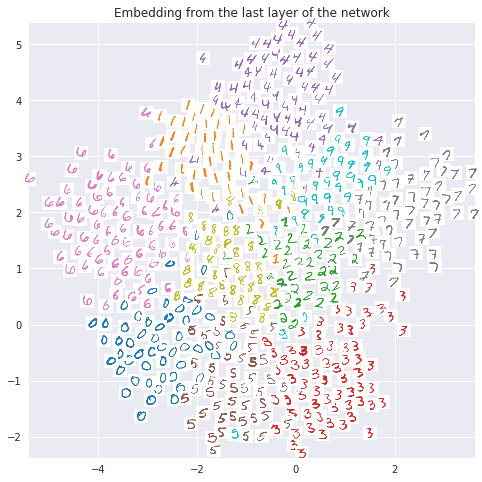

In [11]:
x_test = mnist.test.images.reshape([-1, 28, 28])
y_test = mnist.test.labels

ax_min = np.min(embed,0)
ax_max = np.max(embed,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
colormap = plt.get_cmap('tab10')
shown_images = np.array([[1., 1.]])
for i in range(embed.shape[0]):
    dist = np.sum((embed[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [embed[i]]]
    patch_to_color = np.expand_dims(x_test[i], -1)
    patch_to_color = np.tile(patch_to_color, (1, 1, 3))
    patch_to_color = (1-patch_to_color) * (1,1,1) + patch_to_color * colormap(y_test[i]/10.)[:3]
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(patch_to_color, zoom=0.5, cmap=plt.cm.gray_r),
        xy=embed[i], frameon=False
    )
    ax.add_artist(imagebox)

plt.axis([ax_min[0], ax_max[0], ax_min[1], ax_max[1]])
plt.title('Embedding from the last layer of the network')
plt.show()